## Part 3 of regression analysis
 - focus on using statsmodels module

### The purpose of this notebook is to study relationships between different entities within the transaction data through regression analysis.
 - in partticular, we want to answer the questions whether merchant grow their spending over time. 
 - for simplistic demonstration, we start by running regression on total spent over price, does total spent grow as price increases?
 - note that this may not be a good example of questions, because we have created some correlation already by computiing spent as multiplication of quantity and price price. 
 - a better question to ask is: do merchants increase their spent as their tenures increase? 

### setting up data and utility functions

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import util_transaction_data
from util_transaction_data import *

### preparing the analysis table
 - unit of study is SKU, so we may want to start with a table for SKU attributes, each row for one SKU
 - the values of study are price and spent, but we don't want just one average price and one total spent for the SKU over all times
 - we want to study the changes in spent over price, we want to keep some dimension for variances in the analysis table
 - we can start with price and spent on each week over all merchants: then we want to compute the average price for the week and total spent by the week, for all merchants

In [2]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

In [3]:
sku_week = get_skus_by_week(baskets)

In [21]:
sku_week_970 = sku_week.query("sku_id == 970").reset_index()
sku_week_972 = sku_week.query("sku_id == 972").reset_index()

model = smf.ols(formula='total_spent_by_week ~ avg_price_by_week', 
    data=sku_week_972).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     total_spent_by_week   R-squared:                       0.155
Model:                             OLS   Adj. R-squared:                  0.141
Method:                  Least Squares   F-statistic:                     11.52
Date:                 Fri, 27 Jan 2023   Prob (F-statistic):            0.00120
Time:                         12:18:35   Log-Likelihood:                -1166.9
No. Observations:                   65   AIC:                             2338.
Df Residuals:                       63   BIC:                             2342.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6.338e+07

In [22]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Ordinary least squares
===========================================================================================
Model:                     OLS                        Adj. R-squared:            0.141     
Dependent Variable:        total_spent_by_week        AIC:                       2337.8843 
Date:                      2023-01-27 12:18           BIC:                       2342.2331 
No. Observations:          65                         Log-Likelihood:            -1166.9   
Df Model:                  1                          F-statistic:               11.52     
Df Residuals:              63                         Prob (F-statistic):        0.00120   
R-squared:                 0.155                      Scale:                     2.3705e+14
-------------------------------------------------------------------------------------------
                      Coef.         Std.Err.      t    P>|t|       [0.025         0.975]   
-------------------------------------------------------------------------------------------
Intercept         -63383595.6551 41672826.9929 -1.5210 0.1333 -146660095.3252 19892904.0151
avg_price_by_week       366.8819      108.1084  3.3936 0.0012        150.8445      582.9194
-------------------------------------------------------------------------------------------
Omnibus:                       37.214               Durbin-Watson:                  1.711  
Prob(Omnibus):                 0.000                Jarque-Bera (JB):               95.636 
Skew:                          -1.809               Prob(JB):                       0.000  
Kurtosis:                      7.714                Condition No.:                  8411704
===========================================================================================
* The condition number is large (8e+06). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [23]:
sku_week.loc[:,["logspent"]] = np.log(sku_week["total_spent_by_week"])
sku_week.loc[:,["logprice"]] = np.log(sku_week["avg_price_by_week"])
sku_week_972 = sku_week.query("sku_id == 972").reset_index()

model = smf.ols(formula='logspent ~ logprice', data=sku_week_972).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               logspent   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     8.164
Date:                Fri, 27 Jan 2023   Prob (F-statistic):            0.00578
Time:                        12:18:54   Log-Likelihood:                -17.438
No. Observations:                  65   AIC:                             38.88
Df Residuals:                      63   BIC:                             43.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.1360     11.293     -1.252      0.2

In [6]:
for sku_id, grp in sku_week.groupby('sku_id'):
    model = sm.OLS(grp['total_spent_by_week'], sm.add_constant(grp['avg_price_by_week'])).fit()
    sku_week.loc[sku_week['sku_id'].eq(sku_id), 'beta'] = model.params['avg_price_by_week']

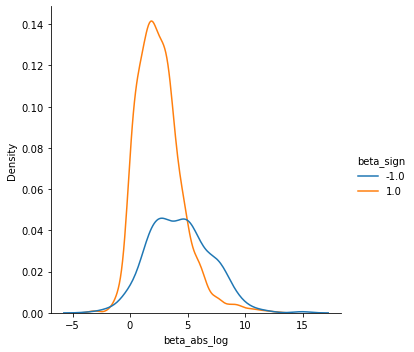

In [7]:
#f, axes = plt.figure(figsize = (20,5))
sku_week_beta = sku_week[["sku_id","beta"]].drop_duplicates()
sku_week_beta["beta_sign"] = pd.Categorical(np.sign(sku_week_beta["beta"]))
sku_week_beta["beta_abs_log"] = np.log(np.abs(sku_week_beta["beta"]))
sns.displot(data=sku_week_beta,x="beta_abs_log",hue="beta_sign", kind='kde')


/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beta', ylabel='Density'>

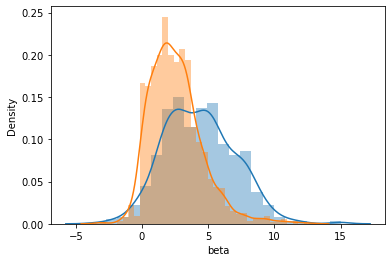

In [8]:
sns.distplot(np.log(np.abs(sku_week_beta[sku_week_beta.beta < 0]["beta"])))
sns.distplot(np.log(sku_week_beta[sku_week_beta.beta > 0]["beta"]))